In [3]:
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import Draw
import tensorflow as tf
from rdkit.Chem import Descriptors as ds
from rdkit.Chem import Fragments as fr

import pandas as pd

from matplotlib import pyplot as plt

import numpy as np

from sklearn import metrics
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

import os

In [4]:
#This is not important, it just gets the number of threads on your CPU and returns that number.
import threading

total_threads =threading.active_count()

In [5]:
# Configure TensorFlow to use multiple CPU cores - This will speed up the training (hopefully)
tf.config.threading.set_inter_op_parallelism_threads(total_threads)
tf.config.threading.set_intra_op_parallelism_threads(total_threads)

In [6]:
#Lets import the dataset - the featurizer and splitter dont matter as we will be combining the datasets and
#designing our own featurizer
tasks, datasets, transformers = dc.molnet.load_tox21(
    featurizer='GraphConv', 
    splitter='random')

train_dataset, valid_dataset, test_dataset = datasets

In [7]:
#Lets convert them to dataframes because deepchem is a piece of shit and it cant handle numpy arrays <-codeium generated this sentence

train_df = train_dataset.to_dataframe()
test_dataset = test_dataset.to_dataframe()
valid_dataset = valid_dataset.to_dataframe()

#This line concatenates all the dataframes meaning all the data is in one dataframe, we will resplit them later with SKLEARN
dataset = pd.concat([train_df, test_dataset, valid_dataset])


#print the columns
dataset.columns

Index(['X', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11',
       'y12', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9', 'w10',
       'w11', 'w12', 'ids'],
      dtype='object')

In [8]:
dataset

,X,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,w4,w5,w6,w7,w8,w9,w10,w11,w12,ids
0,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,1.186419,0.000000,1.058113,0.000000,0.000000,CCOC(=O)C(=O)c1csc(NC=O)n1
1,<deepchem.feat.mol_graphs.ConvMol object at 0x...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.145708,1.050492,1.029118,1.186419,1.038037,1.058113,0.000000,1.063423,CN(CCOc1ccc(NS(C)(=O)=O)cc1)CCc1ccc(NS(C)(=O)=...
2,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.054158,1.145708,1.050492,1.029118,1.186419,1.038037,1.058113,1.182927,1.063423,CCCCCCCCCCCCCCCC(=O)OCC
3,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.054158,1.145708,1.050492,1.029118,0.000000,1.038037,0.000000,1.182927,1.063423,O=c1oc2cc(O)ccc2s1
4,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.054158,1.145708,1.050492,1.029118,6.364256,1.038037,1.058113,6.466667,1.063423,CCOP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1Cl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,6.364256,0.000000,0.000000,0.000000,0.000000,NC(=O)C(=O)NN=Cc1ccc([N+](=O)[O-])o1
779,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.054158,1.145708,1.050492,1.029118,0.000000,1.038037,0.000000,1.182927,1.063423,CC(=O)OC[C@H]1O[C@@H](O)[C@H](OC(=O)c2ccccc2C(...
780,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.054158,1.145708,1.050492,1.029118,6.364256,1.038037,1.058113,1.182927,16.767081,c1cc2ccc3ccc4ccc5cccc6c(c1)c2c3c4c56
781,<deepchem.feat.mol_graphs.ConvMol object at 0x...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.054158,1.145708,1.050492,1.029118,1.186419,1.038037,1.058113,0.000000,16.767081,O=Cc1ccccc1[N+](=O)[O-]


In [9]:
#Lets first select only the useful information, ie the y values (toxicity)
#As well as the ids - ie the smiles strings
data = dataset[['ids', 'y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12']]

# Lets add up all the y values into one 'toxicity measure
col_to_sum = ['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12']

#This adds a new column called 'tox' which is the sum of each row 
data['tox'] = data[col_to_sum].sum(axis=1)
data

,ids,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,tox
0,CCOC(=O)C(=O)c1csc(NC=O)n1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CN(CCOc1ccc(NS(C)(=O)=O)cc1)CCc1ccc(NS(C)(=O)=...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CCCCCCCCCCCCCCCC(=O)OCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,O=c1oc2cc(O)ccc2s1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CCOP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1Cl,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,NC(=O)C(=O)NN=Cc1ccc([N+](=O)[O-])o1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
779,CC(=O)OC[C@H]1O[C@@H](O)[C@H](OC(=O)c2ccccc2C(...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
780,c1cc2ccc3ccc4ccc5cccc6c(c1)c2c3c4c56,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0
781,O=Cc1ccccc1[N+](=O)[O-],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [10]:
#Lets add another row with a binary (1 or 0) that tells us if the compound is toxic against one or more of the assays or not
data['tox_bin'] = data['tox'].apply(lambda x: 1 if x>0 else 0)
data

,ids,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,tox,tox_bin
0,CCOC(=O)C(=O)c1csc(NC=O)n1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,CN(CCOc1ccc(NS(C)(=O)=O)cc1)CCc1ccc(NS(C)(=O)=...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,CCCCCCCCCCCCCCCC(=O)OCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,O=c1oc2cc(O)ccc2s1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,CCOP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1Cl,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,NC(=O)C(=O)NN=Cc1ccc([N+](=O)[O-])o1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
779,CC(=O)OC[C@H]1O[C@@H](O)[C@H](OC(=O)c2ccccc2C(...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
780,c1cc2ccc3ccc4ccc5cccc6c(c1)c2c3c4c56,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,1
781,O=Cc1ccccc1[N+](=O)[O-],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1


In [11]:
#Get rid of the y columns - we dont need them anymore
data.drop(columns=['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12'], inplace=True)

In [12]:
data

,ids,tox,tox_bin
0,CCOC(=O)C(=O)c1csc(NC=O)n1,0.0,0
1,CN(CCOc1ccc(NS(C)(=O)=O)cc1)CCc1ccc(NS(C)(=O)=...,1.0,1
2,CCCCCCCCCCCCCCCC(=O)OCC,0.0,0
3,O=c1oc2cc(O)ccc2s1,0.0,0
4,CCOP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1Cl,3.0,1
...,...,...,...
778,NC(=O)C(=O)NN=Cc1ccc([N+](=O)[O-])o1,1.0,1
779,CC(=O)OC[C@H]1O[C@@H](O)[C@H](OC(=O)c2ccccc2C(...,0.0,0
780,c1cc2ccc3ccc4ccc5cccc6c(c1)c2c3c4c56,3.0,1
781,O=Cc1ccccc1[N+](=O)[O-],1.0,1


## Featurisation of the dataset

Lets get all the features we think we need from the dataset, I have copied richard here but feel free to have a play

In [13]:
import re

#Get all the possible functions within the fr(fragments) module and put them into a list
#This is called a list comprehension it says 'for each element in this list, do this'
#E.g for each name in the directory of the fr module, if the function is callable (i.e. it has a value) then append it to the list
function_names = [name for name in dir(fr) if callable(getattr(fr, name))]

#Remove the first 2 functions (they are not important for us)
function_names.pop(0)
function_names.pop(0)

function_names

['fr_Al_COO',
 'fr_Al_OH',
 'fr_Al_OH_noTert',
 'fr_ArN',
 'fr_Ar_COO',
 'fr_Ar_N',
 'fr_Ar_NH',
 'fr_Ar_OH',
 'fr_COO',
 'fr_COO2',
 'fr_C_O',
 'fr_C_O_noCOO',
 'fr_C_S',
 'fr_HOCCN',
 'fr_Imine',
 'fr_NH0',
 'fr_NH1',
 'fr_NH2',
 'fr_N_O',
 'fr_Ndealkylation1',
 'fr_Ndealkylation2',
 'fr_Nhpyrrole',
 'fr_SH',
 'fr_aldehyde',
 'fr_alkyl_carbamate',
 'fr_alkyl_halide',
 'fr_allylic_oxid',
 'fr_amide',
 'fr_amidine',
 'fr_aniline',
 'fr_aryl_methyl',
 'fr_azide',
 'fr_azo',
 'fr_barbitur',
 'fr_benzene',
 'fr_benzodiazepine',
 'fr_bicyclic',
 'fr_diazo',
 'fr_dihydropyridine',
 'fr_epoxide',
 'fr_ester',
 'fr_ether',
 'fr_furan',
 'fr_guanido',
 'fr_halogen',
 'fr_hdrzine',
 'fr_hdrzone',
 'fr_imidazole',
 'fr_imide',
 'fr_isocyan',
 'fr_isothiocyan',
 'fr_ketone',
 'fr_ketone_Topliss',
 'fr_lactam',
 'fr_lactone',
 'fr_methoxy',
 'fr_morpholine',
 'fr_nitrile',
 'fr_nitro',
 'fr_nitro_arom',
 'fr_nitro_arom_nonortho',
 'fr_nitroso',
 'fr_oxazole',
 'fr_oxime',
 'fr_para_hydroxylation',

In [14]:
#Iterate through the rows in the dataframe
# For each row, create a molecule object from the smiles strings
# For each function in the list of functions, get the value for that function (in this case the total number of each functional group)
#Then add that value to the dataframe for that row with the column heading as the name of the function

for index, row in data.iterrows():
    mol = Chem.MolFromSmiles(row['ids']) # Create molecule object
    for function in function_names: # For each function in functions
        data.at[index, function] = getattr(fr, function)(mol) # Set the value in the dataframe at the molecule index and column name to the value of the function

data

[09:55:21] WARNING: not removing hydrogen atom without neighbors


,ids,tox,tox_bin,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CCOC(=O)C(=O)c1csc(NC=O)n1,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CN(CCOc1ccc(NS(C)(=O)=O)cc1)CCc1ccc(NS(C)(=O)=...,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
2,CCCCCCCCCCCCCCCC(=O)OCC,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
3,O=c1oc2cc(O)ccc2s1,0.0,0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
4,CCOP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1Cl,3.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,NC(=O)C(=O)NN=Cc1ccc([N+](=O)[O-])o1,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
779,CC(=O)OC[C@H]1O[C@@H](O)[C@H](OC(=O)c2ccccc2C(...,0.0,0,0.0,4.0,4.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
780,c1cc2ccc3ccc4ccc5cccc6c(c1)c2c3c4c56,3.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
781,O=Cc1ccccc1[N+](=O)[O-],1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
#We have a list of functional groups, lets also get a binary value for if the molecule matches any of the tests below:
#PAINS, BRENK, NIH

from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from rdkit.Chem import Descriptors as ds

params_pains = FilterCatalogParams()
params_pains.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
pains = FilterCatalog(params_pains)

params_brenk = FilterCatalogParams()
params_brenk.AddCatalog(FilterCatalogParams.FilterCatalogs.BRENK)
brenk = FilterCatalog(params_brenk)

params_nih = FilterCatalogParams()
params_nih.AddCatalog(FilterCatalogParams.FilterCatalogs.NIH)
nih = FilterCatalog(params_nih)


SMILES_strings = data['ids'] # Get smiles strings
mol = [Chem.MolFromSmiles(formula) for formula in SMILES_strings] # Get a list of molecule objects

for row in data.index: # For each row
    molecule = mol[row] # Get the molecule
    data.loc[row, 'pain'] = 1 if pains.HasMatch(molecule) else 0 # Does it match the PAINS filter?
    data.loc[row, 'brenk'] = 1 if pains.HasMatch(molecule) else 0 # Does it match the BRENK filter?
    data.loc[row, 'nih'] = 1 if pains.HasMatch(molecule) else 0 # Does it match the NIH filter?

[09:57:19] WARNING: not removing hydrogen atom without neighbors


In [16]:
data

,ids,tox,tox_bin,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,...,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,pain,brenk,nih
0,CCOC(=O)C(=O)c1csc(NC=O)n1,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CN(CCOc1ccc(NS(C)(=O)=O)cc1)CCc1ccc(NS(C)(=O)=...,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
2,CCCCCCCCCCCCCCCC(=O)OCC,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
3,O=c1oc2cc(O)ccc2s1,0.0,0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
4,CCOP(=S)(OCC)Oc1nc(Cl)c(Cl)cc1Cl,3.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,NC(=O)C(=O)NN=Cc1ccc([N+](=O)[O-])o1,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
779,CC(=O)OC[C@H]1O[C@@H](O)[C@H](OC(=O)c2ccccc2C(...,0.0,0,0.0,4.0,4.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
780,c1cc2ccc3ccc4ccc5cccc6c(c1)c2c3c4c56,3.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
781,O=Cc1ccccc1[N+](=O)[O-],1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


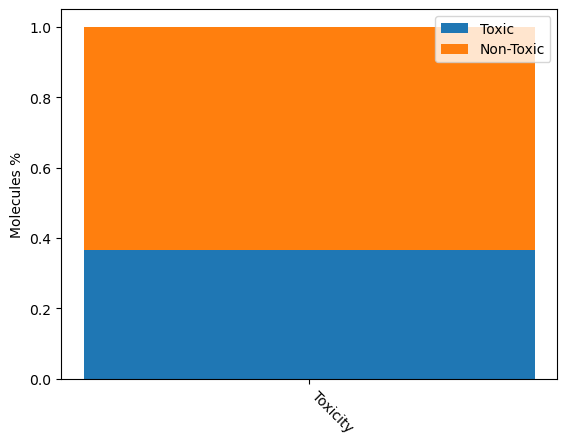

In [17]:
#Lets have a look at the distribution of the data:

percent_toxic = len(data[data['tox_bin'] == 1]) / len(data) # Divides the length of the dataframe where tox_bin == 1 (ie toxic) by the length of the dataframe (all mols)
percent_non_toxic = 1 - percent_toxic


#Lets plot the train_df as a stacked bar graph:
ax=plt.bar('Toxicity',percent_toxic, label='Toxic')
plt.bar('Toxicity',percent_non_toxic, bottom= percent_toxic, label='Non-Toxic')
plt.xticks(rotation=-45, ha='left')
plt.ylabel("Molecules %")
plt.legend()

We can see this dataset is unbalanced so we will need to deal with this before training- but first we need to split the data so we can balance ONLY the training set

In [18]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(data, data['tox_bin'], test_size=0.2) # Split the entire dataset into train and test sets

X_train = X_train.drop(['ids', 'tox', 'tox_bin'], axis=1) # Drop the targets (toxicity indicator) from the X values of the training set
X_test = X_test.drop(['ids', 'tox', 'tox_bin'], axis=1) # Drop the targets (toxicity indicator) from the X values of the test set

X_train


,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,...,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,pain,brenk,nih
4817,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3375,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1958,0.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0


In [19]:
print('Shape of train set: ', X_train.shape)
print('Shape of test set: ', X_test.shape)

Shape of train set:  (6264, 88)
Shape of test set:  (1567, 88)


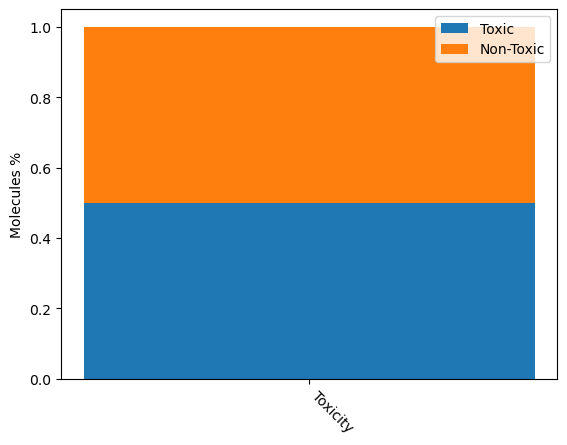

In [20]:
#Lets resample our data - there are a number of ways of doing this but the simplest is to jsut upsample the minority class
#Ie duplicate the samples

from sklearn.utils import resample

#First concatenate the training X and y into one dataframe
train_df = pd.concat([X_train, y_train], axis=1)

#Select the data in the majority and minority class
df_majority = train_df[train_df['tox_bin']==0]
df_minority = train_df[train_df['tox_bin']==1]

#Then resample the minority class - this will duplicate randomly the training data in the minority class to match the number of samples in the majority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results

#Then combine the majority and upsampled minority class
train_df = pd.concat([df_majority, df_minority_upsampled])

#Split them back into X and y values
y_train = train_df['tox_bin']
X_train = train_df.drop(['tox_bin'], axis=1)

#Then lets do what we did above to check it has worked!
percent_toxic = len(y_train[y_train == 1]) / len(y_train)
percent_non_toxic = 1 - percent_toxic


#Lets plot the train_df as a stacked bar graph:
ax=plt.bar('Toxicity',percent_toxic, label='Toxic')
plt.bar('Toxicity',percent_non_toxic, bottom= percent_toxic, label='Non-Toxic')
plt.xticks(rotation=-45, ha='left')
plt.ylabel("Molecules %")
plt.legend()

Perfect, this looks perfectly balanced

In [21]:
#Lets now split our test set into vaL and test sets
#Test will be used to test our model at the END of training
#Whereas validation will be used to test the model DURING training

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

print('Shape of test set: ', X_test.shape)
print('Shape of validation set: ', X_val.shape)

Shape of test set:  (783, 88)
Shape of validation set:  (784, 88)


In [22]:
#In order for the model to work, we first have to convert our dataframes into tensors:

X_train_array = X_train.values
X_test_array = X_test.values
X_val_array = X_val.values

y_train_array = y_train.values
y_test_array = y_test.values
y_val_array = y_val.values

X_train_tensor = tf.convert_to_tensor(X_train_array)
X_test_tensor = tf.convert_to_tensor(X_test_array)
X_val_tensor = tf.convert_to_tensor(X_val_array)

y_train_tensor = tf.convert_to_tensor(y_train_array)
y_test_tensor = tf.convert_to_tensor(y_test_array)
y_val_tensor = tf.convert_to_tensor(y_val_array)

In [23]:
#This function is simply creating a tensorflow keras model for our machine learning
#I have initialised it inside a function as it will allow me to search through all different combinations of parameters
# e.g number of dense neurones, dropout rate, etc.

def init_keras_model(dense1=700, dense2=100, dropout=0.7, optimizer='adam', callbacks=[]):

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(dense1, activation='relu'), # Create a fully connected dense layer with dense1 number of neurons
        tf.keras.layers.BatchNormalization(), # Batch normalisation reduces variability of our model
        tf.keras.layers.Dropout(rate=dropout), # Dropout will reduce overtraining
        tf.keras.layers.Dense(dense2, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=dropout),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(1, activation='sigmoid') # output layer
    ])

    # Call backs are a way of monitoring our model during training, for example to reduce the learning rate or save the best model as we go
    #If callbacks is empty, compile the model without them
    if callbacks == []: 
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy'],
        )
    else: # If we specify callbacks the model will be compiled with them
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy'],
            callbacks=callbacks
        )
    
    return model

In [22]:
LEARNING_RATE = 0.001 # This is how fast the model should learn
n_epochs = 200 # This is how many times to train the model 
# (more epochs may lead to better accuracy but will also lead to overfitting)

adam = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) # The optimizer is Adam and is the algorithm used to train the model
lrr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=15, verbose=1, factor=0.5, min_lr=0.00001) # Reduce learning rate on plateau tells the model to reduce the speed at which it learns when it gets close to converging.
mc = tf.keras.callbacks.ModelCheckpoint(filepath='weights_chk.h5',
                                        monitor='val_accuracy',
                                        verbose=0,
                                        save_best_only=True,
                                        save_weights_only=True,
                                        mode='max') # Model Checkpoint is used to save the best model during training



#precision = tf.keras.metrics.Precision()
#recall = tf.keras.metrics.Recall()

keras_model = init_keras_model() # Initialise the model


history = keras_model.fit(X_train_tensor, 
                          y_train_tensor, 
                          epochs=n_epochs, 
                          validation_data=(X_val_tensor, y_val_tensor), 
                          ) # Fit the model

Epoch 1/200

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

249/249 [==============================] - 1s 4ms/step - loss: 0.7803 - accuracy: 0.5458 - val_loss: 0.6621 - val_accuracy: 0.6314
Epoch 2/200
249/249 [==============================] - 1s 4ms/step - loss: 0.7147 - accuracy: 0.5570 - val_loss: 0.6428 - val_accuracy: 0.6454
Epoch 3/200
249/249 [==============================] - 1s 3ms/step - loss: 0.6825 - accuracy: 0.5867 - val_loss: 0.6389 - val_accuracy: 0.6429
Epoch 4/200
249/249 [==============================] - 1s 3ms/step - loss: 0.67

### Plot the loss & accuracy

This will plot the loss (how far each prediction is from the truth) - lower is better
And the accuracy measures the % of correct predictions - higher is better

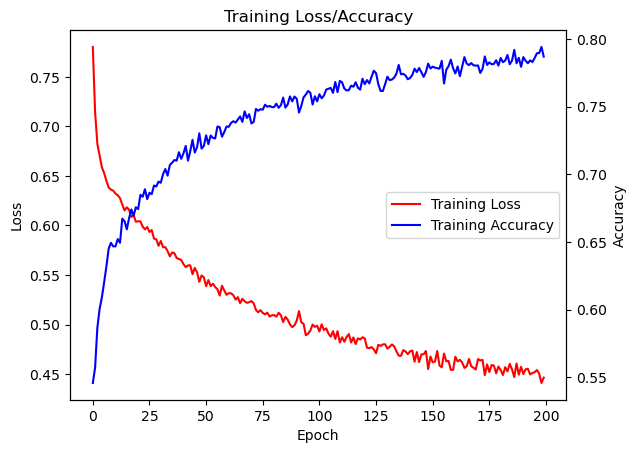

In [23]:



fig, ax1 = plt.subplots()
# Plot the training loss
ax1.plot(history.history['loss'], label='Training Loss', c='red')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2=ax1.twinx()

ax2.plot(history.history['accuracy'], label='Training Accuracy', c='blue')
ax2.set_ylabel('Accuracy')
plt.title('Training Loss/Accuracy')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')


plt.show()

### Plot the training accuracy and validation accuracy

This will tell us if the model is overfitting (training accuracy increases and val accuracy decreases)

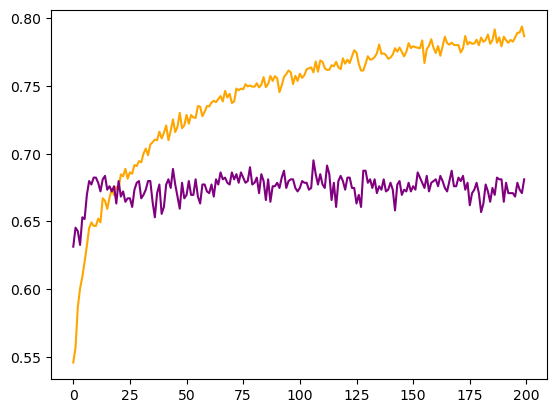

In [24]:
plt.plot(history.history['accuracy'], label='Training Accuracy', c='orange')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', c='purple')

# THIS BLOCK WILL TAKE A LONG TIME, DO NOT RUN

In [28]:
# Lets explore some parameters:
scores = {}

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30) # Early stop will stop training when the model has failed to improve

dense1 = [700, 850, 1000]
dense2 = [100, 250, 400]
dropout = [0.5, 0.7, 0.9]
optimizer = ['sgd']

best_score = float('-inf')
best_params = {}

for d1 in dense1:
    for d2 in dense2:
        for dr in dropout:
            for opt in optimizer:
                print('Calculating for:', d1, d2, dr, opt)
                keras_model = init_keras_model(dense1=d1, dense2=d2, dropout=dr, optimizer=opt)
                keras_model.fit(X_train_tensor, 
                                y_train_tensor, 
                                epochs=n_epochs, 
                                validation_data=(X_val_tensor, y_val_tensor),
                                callbacks=[es] 
                                )
                score = keras_model.evaluate(X_test_tensor, y_test_tensor, verbose=0)[1]
                scores[(d1, d2, dr, opt)] = score
                
                if score > best_score:
                    best_score = score
                    best_params = {'dense1':d1, 'dense2':d2, 'dropout':dr, 'optimizer':opt}

Calculating for: 700 100 0.5 sgd
Epoch 1/200

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



249/249 [==============================] - 1s 3ms/step - loss: 0.8133 - accuracy: 0.5534 - val_loss: 0.6403 - val_accuracy: 0.6543
Epoch 2/200
249/249 [==============================] - 1s 3ms/step - loss: 0.7064 - accuracy: 0.5697 - val_loss: 0.6339 - val_accuracy: 0.6684
Epoch 3/200
249/249 [==============================] - 1s 3ms/step - loss: 0.6776 - accuracy: 0.5836 - val_loss: 0.6391 - val_accuracy: 0.6633
Epoch 4/200
249/249 [==============================] - 1s 3ms/step - loss: 0.6664 - accuracy: 0.5942 - val_loss: 0.6358 - val_accuracy: 0.6684
Epoch 5/200
249/249 [==============================] - 1s 3ms/step - loss: 0.6599 - accuracy: 0.6112 - val_loss: 0.6298 - val_accuracy: 0.6786
Epoch 6/200
249/249 [==============================] - 1s 3ms/step - loss: 0.6608 - accuracy: 0.6150 - val_loss: 0.6304 - val_accuracy: 0.6760
Epoch 7/200
249/249 [==============================] - 1s 3ms/step - loss: 0.6601 - accuracy: 0.6011 - val_loss: 0.6292 - val_accuracy: 0.6824
Epoch 8/200

In [29]:
print(scores)

{(700, 100, 0.5, 'sgd'): 0.6743295192718506, (700, 100, 0.7, 'sgd'): 0.6858237385749817, (700, 100, 0.9, 'sgd'): 0.6692209243774414, (700, 250, 0.5, 'sgd'): 0.671775221824646, (700, 250, 0.7, 'sgd'): 0.6615580916404724, (700, 250, 0.9, 'sgd'): 0.6704980731010437, (700, 400, 0.5, 'sgd'): 0.6730523705482483, (700, 400, 0.7, 'sgd'): 0.6628352403640747, (700, 400, 0.9, 'sgd'): 0.6692209243774414, (850, 100, 0.5, 'sgd'): 0.6743295192718506, (850, 100, 0.7, 'sgd'): 0.6602809429168701, (850, 100, 0.9, 'sgd'): 0.6743295192718506, (850, 250, 0.5, 'sgd'): 0.6513410210609436, (850, 250, 0.7, 'sgd'): 0.679438054561615, (850, 250, 0.9, 'sgd'): 0.671775221824646, (850, 400, 0.5, 'sgd'): 0.6602809429168701, (850, 400, 0.7, 'sgd'): 0.6704980731010437, (850, 400, 0.9, 'sgd'): 0.6756066679954529, (1000, 100, 0.5, 'sgd'): 0.6679438352584839, (1000, 100, 0.7, 'sgd'): 0.6666666865348816, (1000, 100, 0.9, 'sgd'): 0.6730523705482483, (1000, 250, 0.5, 'sgd'): 0.679438054561615, (1000, 250, 0.7, 'sgd'): 0.6768

In [30]:
print(f'best_params: {best_params}, best_score: {best_score}')

best_params: {'dense1': 700, 'dense2': 100, 'dropout': 0.7, 'optimizer': 'sgd'}, best_score: 0.6858237385749817


In [31]:
dense1 = [650, 700, 750]
dense2 = [50, 100, 150]
dropout = [0.6, 0.7, 0.8]


for d1 in dense1:
    for d2 in dense2:
        for dr in dropout:
            print('Calculating for:', d1, d2, dr, opt)
            keras_model = init_keras_model(dense1=d1, dense2=d2, dropout=dr, optimizer=opt)
            keras_model.fit(X_train_tensor, 
                            y_train_tensor, 
                            epochs=n_epochs, 
                            validation_data=(X_val_tensor, y_val_tensor),
                            callbacks=[es] 
                            )
            score = keras_model.evaluate(X_test_tensor, y_test_tensor, verbose=0)[1]
            scores[(d1, d2, dr, opt)] = score
            
            if score > best_score:
                best_score = score
                best_params = {'dense1':d1, 'dense2':d2, 'dropout':dr, 'optimizer':opt}

Calculating for: 650 50 0.6 sgd
Epoch 1/200

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

249/249 [==============================] - 1s 3ms/step - loss: 0.8221 - accuracy: 0.5309 - val_loss: 0.6546 - val_accuracy: 0.6467
Epoch 2/200
249/249 [==============================] - 1s 3ms/step - loss: 0.7168 - accuracy: 0.5504 - val_loss: 0.6543 - val_accuracy: 0.6454
Epoch 3/200
249/249 [==============================] - 1s 3ms/step - loss: 0.6942 - accuracy: 0.5605 - val_loss: 0.6454 - val_accuracy: 0.6531
Epoch 4/200
249/249 [==========================

In [32]:
print(f'best_params: {best_params}, best_score: {best_score}')

best_params: {'dense1': 750, 'dense2': 50, 'dropout': 0.8, 'optimizer': 'sgd'}, best_score: 0.6883780360221863


In [25]:
n_epochs = 500

model = init_keras_model(dense1=750, dense2=150, dropout=0.8, optimizer='sgd')

history = model.fit(X_train_tensor,
          y_train_tensor,
          epochs=n_epochs,
          validation_data=(X_val_tensor, y_val_tensor),
          )



Epoch 1/500

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

248/248 [==============================] - 1s 3ms/step - loss: 0.8071 - accuracy: 0.5182 - val_loss: 0.6550 - val_accuracy: 0.6684
Epoch 2/500
248/248 [==============================] - 1s 2ms/step - loss: 0.7157 - accuracy: 0.5388 - val_loss: 0.6495 - val_accuracy: 0.6684
Epoch 3/500
248/248 [==============================] - 1s 2ms/step - loss: 0.6957 - accuracy: 0.5455 - val_loss: 0.6400 - val_accuracy: 0.6645
Epoch 4/500
248/248 [==============================] - 1s 2ms/step - loss: 0.68

In [26]:
def plot_curves(history):
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(history.history['loss'], label='Training Loss', c='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax2 = ax1.twinx()
    ax2.plot(history.history['accuracy'], label='Training Accuracy', c='blue')
    ax2.set_ylabel('Accuracy')
    ax1.set_title('Training Loss/Accuracy')


    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='lower right')



    ax3 = plt.subplot(1, 2, 2)
    ax3.plot(history.history['val_accuracy'], label='Validation Accuracy', c='purple')
    ax3.set_ylabel('Accuracy')
    ax3.set_xlabel('Epoch')

    ax3.plot(history.history['accuracy'], label='Training Accuracy', c='orange')
    ax3.set_title('Training Accuracy/Validation Accuracy')
    ax3.legend(loc='lower right')


    plt.tight_layout()
    plt.show()
    


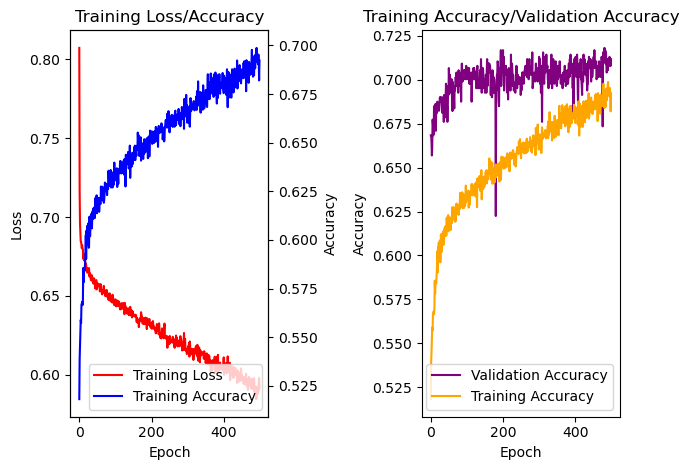

In [27]:
plot_curves(history)

In [29]:
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

y_pred = model.predict(X_test_tensor)


f1score = f1_score(y_test_tensor, y_pred.round(), average='micro')
f2score = fbeta_score(y_test_tensor, y_pred.round(), beta=2, average='micro')


print(f'F1 score: {f1score} \nF2 score: {f2score}')


F1 score: 0.6743295019157088 
F2 score: 0.6743295019157088


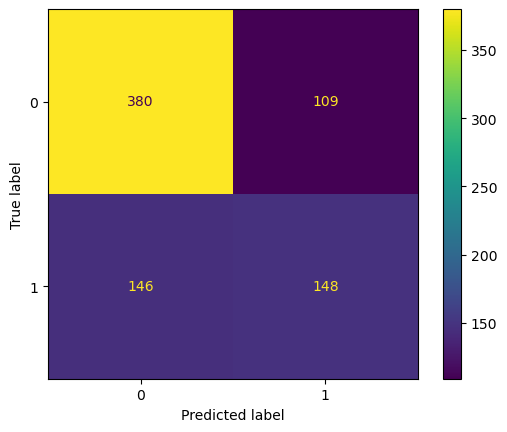

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_tensor, y_pred.round())
ConfusionMatrixDisplay(cm).plot()

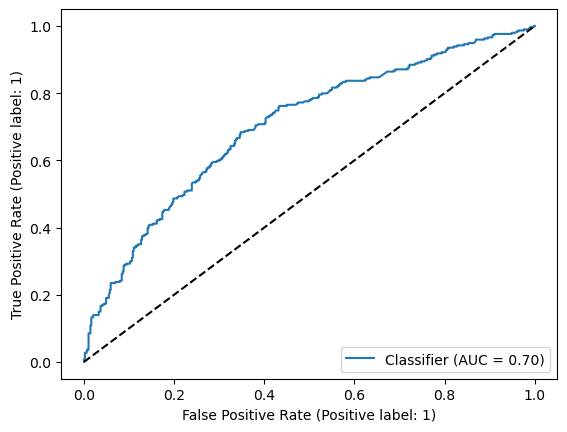

In [31]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score

roc_score = roc_auc_score(y_test_tensor, y_pred)
RocCurveDisplay.from_predictions(y_test_tensor, y_pred)
plt.plot([0, 1], [0, 1], 'k--')

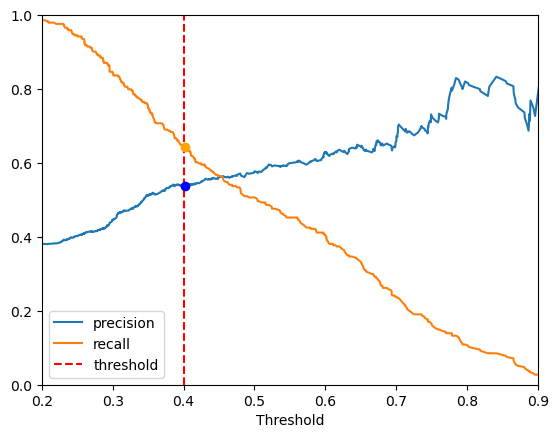

In [32]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, thresholds = precision_recall_curve(y_test_tensor, y_pred)

threshold = 0.4

idx = (thresholds >= threshold).argmax()

plt.plot(thresholds, precision[:-1], label='precision')
plt.plot(thresholds, recall[:-1], label='recall')
plt.vlines(threshold, 0, 1.0, colors='r', linestyles='--', label='threshold')

plt.plot(thresholds[idx], precision[idx], 'bo')
plt.plot(thresholds[idx], recall[idx], 'o', c='orange')

plt.axis([0.2, 0.9, 0, 1])

plt.xlabel('Threshold')
plt.legend()

plt.legend()

F2 score: 0.573936529372046


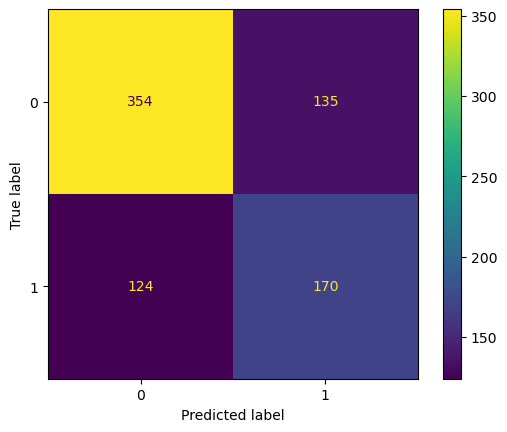

In [38]:
#Since we want to minimise false negatives, we should favour recall over precision
from sklearn.metrics import fbeta_score



threshold = 0.5

y_pred = model.predict(X_test_tensor)

y_pred = np.where(y_pred >= threshold, 1, 0)

score = fbeta_score(y_test_tensor, y_pred, beta=2)
print(f'F2 score: {score}')



cm = confusion_matrix(y_test_tensor, y_pred)
ConfusionMatrixDisplay(cm).plot()

Best threshold: 0.23 
Best F2 score: 0.7509157509157509


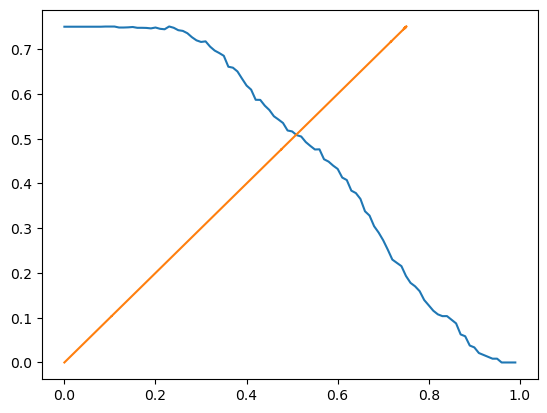

In [42]:
#Determine the ideal threshold for f2

threshold_dict = {}
best_score = float('-inf')
best_threshold = 0

for i in range(0,100, 1):
    
    threshold = i/100

    y_pred = model.predict(X_test_tensor)

    y_pred = np.where(y_pred >= threshold, 1, 0)

    score = fbeta_score(y_test_tensor, y_pred, beta=2)

    threshold_dict[threshold] = score
    
    if score > best_score:
        best_score = score
        best_threshold = threshold


threshold_df = pd.DataFrame(threshold_dict.items(), columns=['threshold', 'f2score'])


Best threshold: 0.23 
Best F2 score: 0.7509157509157509


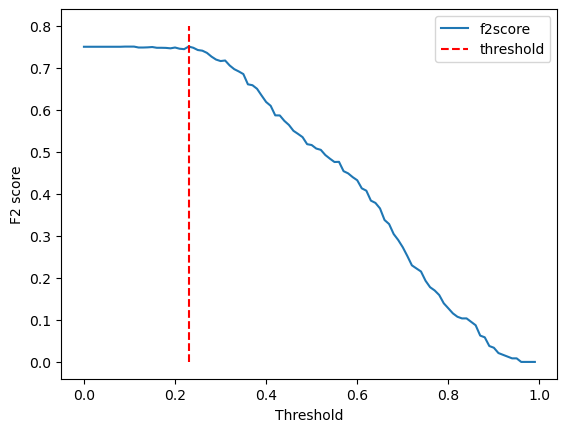

In [47]:
plt.plot(threshold_df['threshold'], threshold_df['f2score'], label='f2score')

plt.vlines(best_threshold, 0, 0.8, colors='r', linestyles='--', label='threshold')

plt.xlabel('Threshold')
plt.ylabel('F2 score')
plt.legend()
print(f'Best threshold: {best_threshold} \nBest F2 score: {best_score}')

F1 score: 0.5578231292517006 
F2 score: 0.7509157509157509 
 Accuracy: 0.41890166028097064


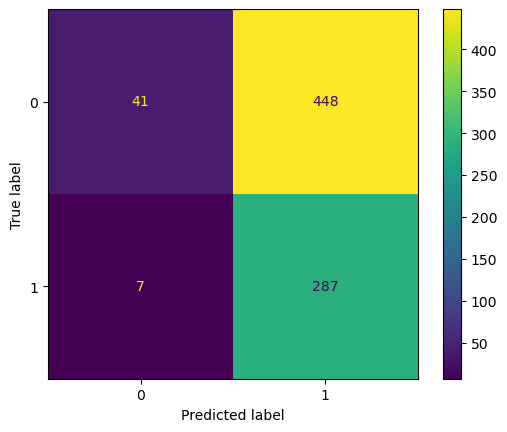

In [49]:
#This looks like a really high f2 but I can already presume that the confusion matrix will look horrible (super high false positives)
#Lets take a look
from sklearn.metrics import accuracy_score

y_pred = np.where(model.predict(X_test_tensor) >= best_threshold, 1, 0)

f1 = f1_score(y_test_tensor, y_pred)
f2 = fbeta_score(y_test_tensor, y_pred, beta=2)
accuracy = accuracy_score(y_test_tensor, y_pred)

print(f'F1 score: {f1} \nF2 score: {f2} \n Accuracy: {accuracy}')


cm = confusion_matrix(y_test_tensor, y_pred)
ConfusionMatrixDisplay(cm).plot()

In [69]:
#Lets try the same, taking into account both f1 and f2

best_threshold = {}
best_f1_score = 0
best_f2_score = 0
best_combined_score = 0
best_accuracy_score = 0

threshold_scores = {}


for i in range(1,100, 1):
    
    threshold = i/100

    y_pred = np.where(model.predict(X_test_tensor) >= threshold, 1, 0)

    f1 = f1_score(y_test_tensor, y_pred)
    f2 = fbeta_score(y_test_tensor, y_pred, beta=2)
    accuracy = accuracy_score(y_test_tensor, y_pred)

    combined_score = (f1 + f2) / 2

    threshold_scores[threshold] = (f1, f2, accuracy, combined_score)

    if combined_score > best_combined_score:
        best_combined_score = combined_score
        best_threshold['combined'] = threshold

    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold['f1'] = threshold

    if f2 > best_f2_score:
        best_f2_score = f2
        best_threshold['f2'] = threshold

    if accuracy > best_accuracy_score:
        best_accuracy_score = accuracy
        best_threshold['accuracy'] = threshold

threshold_scores_df = pd.DataFrame.from_dict(threshold_scores, orient='index', columns=['f1', 'f2', 'accuracy', 'combined'])

threshold_scores_df


,f1,f2,accuracy,combined
0.01,0.545961,0.750383,0.375479,0.648172
0.02,0.545961,0.750383,0.375479,0.648172
0.03,0.545961,0.750383,0.375479,0.648172
0.04,0.545961,0.750383,0.375479,0.648172
0.05,0.545961,0.750383,0.375479,0.648172
...,...,...,...,...
0.95,0.013514,0.008489,0.627075,0.011001
0.96,0.000000,0.000000,0.624521,0.000000
0.97,0.000000,0.000000,0.624521,0.000000
0.98,0.000000,0.000000,0.624521,0.000000


Text(0, 0.5, 'Score')

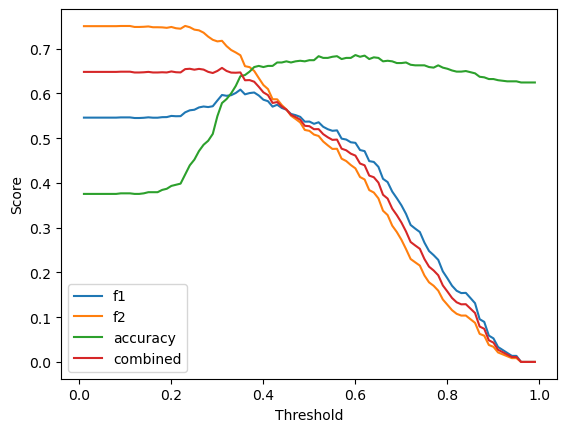

In [67]:
threshold_scores_df.plot()

plt.xlabel('Threshold')
plt.ylabel('Score')



In [70]:
print(f'''Best F1 score: {best_f1_score} at threshold: {best_threshold["f1"]}
      Best F2 score: {best_f2_score} at threshold: {best_threshold["f2"]}
      Best Accuracy score: {best_accuracy_score} at threshold: {best_threshold["accuracy"]}
      Best Combined score: {best_combined_score} at threshold: {best_threshold["combined"]}''')

Best F1 score: 0.6085753803596128 at threshold: 0.35
      Best F2 score: 0.7509157509157509 at threshold: 0.23
      Best Accuracy score: 0.685823754789272 at threshold: 0.6
      Best Combined score: 0.6571120379692219 at threshold: 0.31


In [73]:
threshold_list = list(best_threshold.values())
print(threshold_list)

combined_threshold = np.average(threshold_list)
combined_threshold

[0.31, 0.35, 0.23, 0.6]


0.37249999999999994

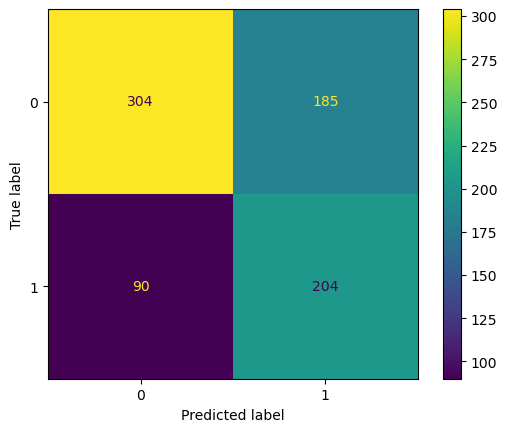

In [74]:
y_pred = np.where(model.predict(X_test_tensor) >= combined_threshold, 1, 0)

cm = confusion_matrix(y_test_tensor, y_pred)
ConfusionMatrixDisplay(cm).plot()